### Importing Libraries

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import os

### Data pre-processing

In [2]:
df = pd.read_csv('C:/Users/chira/Projects/AIML Lab/Assignments/Assignment 1/Assignment-1/input/train.csv')
df1 = df.sample(frac = 1)
df1.reset_index(inplace = True, drop = True)

In [3]:
def train_val_test_split(df, val_size, test_size):
    val_size = int(len(df) * val_size)
    test_size = int(len(df) * test_size)
    train_data, val_data, test_data = df[test_size+val_size:], df[val_size:test_size+val_size], df[:test_size]
    train_data.reset_index(inplace = True, drop = True)
    val_data.reset_index(inplace = True, drop = True)
    test_data.reset_index(inplace = True, drop = True)
    return train_data, val_data, test_data

def normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / std

def getData(data, val_size, test_size):
    train, val, test = train_val_test_split(data, val_size, test_size)
    train_x = normalize(torch.from_numpy(train.iloc[:,1:].values.reshape(-1,1,28,28)).float())
    train_y = torch.from_numpy(train.iloc[:,0].values.reshape(-1,1)).squeeze(1).long()
    val_x = normalize(torch.from_numpy(val.iloc[:,1:].values.reshape(-1,1,28,28)).float())
    val_y = torch.from_numpy(val.iloc[:,0].values.reshape(-1,1)).squeeze(1).long()
    test_x = normalize(torch.from_numpy(test.iloc[:,1:].values.reshape(-1,1,28,28)).float())
    test_y = torch.from_numpy(test.iloc[:,0].values.reshape(-1,1)).squeeze(1).long()
    return train_x, train_y, val_x, val_y, test_x, test_y

### Model Architecture

In [4]:
# switch to False to use CPU
torch.cuda.is_available()
use_cuda = False
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, 40)
        self.fc4 = nn.Linear(40, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.fc4(x)
        return x

### Early Stopping

In [6]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'C:/Users/chira/Projects/AIML Lab/Assignments/Assignment 1/Assignment-1/model/model.pt')
        self.val_loss_min = val_loss

### Training

In [7]:
def train(model, device, x_train, t_train, x_val, t_val, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = x_train[start:end], t_train[start:end]
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()

    # Training accuracy calculation
    _, train_accuracy = test(model, device, x_train, t_train, batch_size=256, mode="train")

    # Validation loss and accuracy calculation
    val_loss, val_accuracy = test(model, device, x_val, t_val, batch_size=256, mode="val")

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tValidation Loss: {:.4f} \tValidation Accuracy: {:.2f}%'.format(epoch, loss.item(), train_accuracy, val_loss, val_accuracy))
    return loss.item(), train_accuracy, val_loss, val_accuracy

def test(model, device, x_data, t_data, batch_size, mode="test"):
    model.eval()
    data_size = len(t_data)
    total_loss = 0
    correct = 0

    for start in range(0, data_size-1, batch_size):
        end = start + batch_size
        with torch.no_grad():
            x, y = x_data[start:end], t_data[start:end]
            x, y = x.to(device), y.to(device)
            output = model(x)
            total_loss += F.cross_entropy(output, y).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max logit
            correct += pred.eq(y.view_as(pred)).sum().item()

    total_loss /= len(t_data)
    accuracy = 100. * correct / len(t_data)
    if mode == 'test':
      print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
          mode.capitalize(), total_loss, correct, len(t_data), accuracy))

    return total_loss, accuracy

In [10]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)
early_stopping = EarlyStopping(patience=4, verbose=True)
train_x, train_y, val_x, val_y, test_x, test_y = getData(df1, val_size = 0.1, test_size = 0.1)
epochs = 40
for epoch in range(1, epochs + 1):
  _, _, val_loss, _ = train(model, device, train_x, train_y, val_x, val_y, optimizer, epoch)
  early_stopping(val_loss, model)
  if early_stopping.early_stop:
    print("Early stopping")
    break
test(model, device, test_x, test_y, batch_size=256)

Epoch: 1 	Training Loss: 0.422490 	Training Accuracy: 94.32% 	Validation Loss: 0.0010 	Validation Accuracy: 94.07%
Validation loss decreased (inf --> 0.000954).  Saving model ...
Epoch: 2 	Training Loss: 0.170231 	Training Accuracy: 96.74% 	Validation Loss: 0.0005 	Validation Accuracy: 96.29%
Validation loss decreased (0.000954 --> 0.000539).  Saving model ...
Epoch: 3 	Training Loss: 0.236740 	Training Accuracy: 97.09% 	Validation Loss: 0.0005 	Validation Accuracy: 96.62%
Validation loss decreased (0.000539 --> 0.000482).  Saving model ...
Epoch: 4 	Training Loss: 0.087504 	Training Accuracy: 97.75% 	Validation Loss: 0.0004 	Validation Accuracy: 97.60%
Validation loss decreased (0.000482 --> 0.000391).  Saving model ...
Epoch: 5 	Training Loss: 0.099783 	Training Accuracy: 98.11% 	Validation Loss: 0.0004 	Validation Accuracy: 97.83%
Validation loss decreased (0.000391 --> 0.000350).  Saving model ...
Epoch: 6 	Training Loss: 0.106465 	Training Accuracy: 98.10% 	Validation Loss: 0.0003

(0.0002415250184103137, 98.5952380952381)

### Handling of test_images

C:\Users\chira\AppData\Local\Temp\ipykernel_30512\2509342156.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  plt.imshow(torch.from_numpy(img.imread('C:/Users/chira/Projects/AIML Lab/Assignments/Assignment 1/Assignment-1/test_images/img_{}.jpg'.format(i+1))))


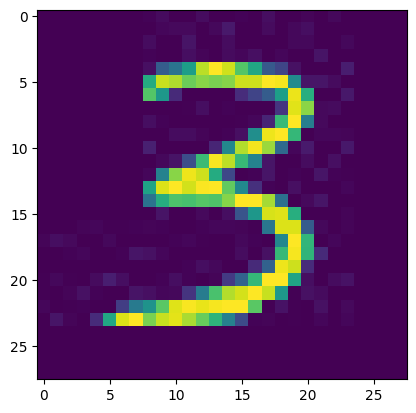

In [9]:
for i in range(10):
    plt.imshow(torch.from_numpy(img.imread('C:/Users/chira/Projects/AIML Lab/Assignments/Assignment 1/Assignment-1/test_images/img_{}.jpg'.format(i+1))))